# Regression multiple pour NLP
## Entrainement d'un modèle prédisant la note d'un commentaire par l'analyse de son contenu.

In [62]:
import numpy as np
import os, glob
import pandas as pd
from scipy import stats
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from nltk.tokenize import word_tokenize

Aggregation et chargement des données obtenues par scrap.py

In [2]:
files = glob.glob("data/*")
multi_df = (pd.read_csv(f,sep='\t') for f in files)
data = pd.concat(multi_df, ignore_index=True)

Seuls le texte et la note nous intéressent ici.

 La note est sur une échelle de 10 (50 représente 5 sur 5 et 10 représente 1 sur 5)

In [3]:
data = data[["review","rating"]]
data.iloc[0:5,:] 

,review,rating
0,"Ambiance au top entre amis, en couple la direc...",50
1,"Accueil, Ambiance et Boissons au Top. L'un des...",50
2,Allez-y pour le mojito framboise et la barmaid...,50
3,Tout simplement les meilleurs mojitos de Marse...,50
4,Un bon accueil des tables dehors ou un sous so...,40


Nous faisons l'hypothèse que :
- le nombre de mots d'une review aurait tendance à grandir au plus celle-ci est négative
- la valence émotionnelle d'une review serait plus élevée pour des reviews positives

Mesure de la taille des reviews

In [4]:
vec = CountVectorizer(lowercase=False)
dtm = vec.fit_transform(data['review'])
length_phrases = dtm.sum(1).ravel().tolist()[0]
data['nb_mots'] = length_phrases

### On peut observer une faible correlation négative entre ces deux variables.

In [5]:
np.corrcoef(length_phrases,data['rating'])[0,1]

-0.2594317240390699

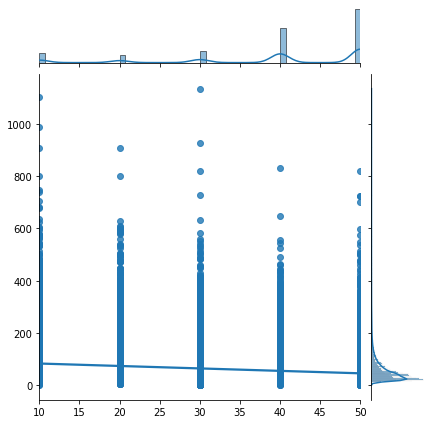

In [6]:
sns.jointplot(x = list(data['rating'].ravel()), y = length_phrases,kind="reg");

Qu'en est-il de la valence émotionnelle ?

In [7]:
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
def get_sentiment(text):
    blob = tb(text)
    return(blob.sentiment[0])

In [8]:
sents = list()
for rev in data['review']:
    sents.append(get_sentiment(rev))
data['sentiment'] = sents

### On observe une correlation modérée entre la note attribuée et la valence du vocabulaire

In [9]:
np.corrcoef(sents,data['rating'])[0,1]

0.5890563866227738

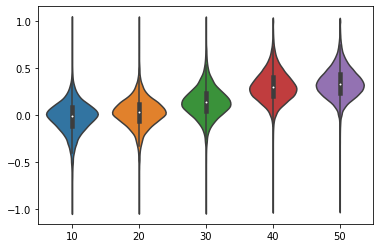

In [10]:
sns.violinplot(x = list(data['rating'].ravel()), y =sents);

### Entrainement du modèle
Découpage en train et test

In [11]:
rdm_data = data.sample(frac=1)
mask = np.random.rand(len(data)) < 0.8
train = rdm_data[mask]
test = rdm_data[~mask]

Regression multiple basée sur la forme matricielle des équations normales.


In [12]:
def regression(X,Y):
    var_names = X.columns
    X = X.to_numpy()
    X = np.hstack((np.ones(len(Y)).reshape(len(Y),1),X.reshape(len(Y),X.shape[1])))
    b = np.linalg.inv(X.T.dot(X)).dot(X.T.dot(Y))
    n = X.shape[0]
    k = X.shape[1]
    ddl1 = k-1
    ddl2 = n-k
    SSE = (Y-X.dot(b)).T.dot(Y-X.dot(b))
    SST = np.sum((Y-Y.mean())**2)
    SSR = SST - SSE
    MSE = SSE/ddl2
    MSR = SSR/ddl1
    F = (MSR / MSE).ravel()[0]
    P = 1 - stats.f.cdf(F,ddl1,ddl2)
    R_carre = (SSR/SSE).ravel()[0]
    R_carre_aj = 1 - (1-R_carre)* ((n-1)/(n-k-1))
    S_carre = SSE/(n-k)
    std_err = np.reshape(np.diag(np.linalg.inv(X.T.dot(X))) * S_carre,(len(b),1))
    t = list((b / std_err.T).ravel())
    p_value = list()
    lower_95 = list()
    upper_95 = list()
    for i in list(range(0,len(t))):
        p_value.append(1- stats.t.cdf(np.sqrt(t[i]**2),df=ddl2))
        upper_95.append(stats.t.ppf(1-0.025,ddl2)*std_err[i])
        lower_95.append(stats.t.ppf(0.025,ddl2)*std_err[i])
        output_regression = {"variable":['intercept']+list(var_names),
                        "coefs":b.ravel(),
                        "erreur standard":std_err.ravel(),
                        "t":t,
                        "valeur P":p_value,
                        "limite haute (95%)":upper_95,
                        "limite basse (95%)":lower_95}
    print(f'F calculé = {F} | P = {P}')
    print(f'R² = {R_carre} | R² ajusté = {R_carre_aj}')
    return(pd.DataFrame(output_regression))

In [13]:
regression(train[['sentiment','nb_mots']],train['rating'])

F calculé = 37173.40528892214 | P = 1.1102230246251565e-16
R² = 0.5558058265141913 | R² ajusté = 0.5557958642486884


,variable,coefs,erreur standard,t,valeur P,limite haute (95%),limite basse (95%)
0,intercept,32.188351,4.036027e-03,7975.256677,0.0,[0.007910539016989163],[-0.007910539016989165]
1,sentiment,34.324905,1.948144e-02,1761.928876,0.0,[0.03818325845218634],[-0.03818325845218635]
2,nb_mots,-0.027186,3.979689e-07,-68310.792686,0.0,[7.800118654096907e-07],[-7.800118654096909e-07]


Le modèle et ses paramètres semblent statistiquement significatifs mais quelles sont ses performances sur des données jamais vues ? 

In [71]:
def predict_rating(phrase):
    b0 = 32.188351
    b1 = 34.104734
    b2 = -0.027427
    x1 = get_sentiment(phrase)
    x2 = len(word_tokenize(phrase))
    return(b0 + b1*x1 + b2*x2)

Intuitivement, ce dernier semble donner des resultats cohérents

In [70]:
phrase1 = "je suis content d'avoir mangé là bas. La nourriture était exquise et le service parfait"
phrase2 = "je suis décu d'avoir mangé là bas. la nourriture était mauvaise et le service incompétent"

In [96]:
predict_rating(phrase1) # une valeur proche d'un 5 sur 5 

47.522958475

In [97]:
predict_rating(phrase2) # valeur entre 1 et 2 

16.231865029999998

La racide de l'erreur quadratique moyenne peut nous renseigner sur la précision du modèle

In [50]:
def testeur(X,Y):
    n = len(X)
    b = np.array([32.269239,34.104734,-0.027427])
    X = np.hstack((np.ones(len(X)).reshape(len(X),1),X.to_numpy()))
    predictions = X.dot(b)
    RMSE = np.sqrt(np.sum((predictions-Y)**2)/n)
    return(RMSE)
    

In [52]:
testeur(test[['sentiment','nb_mots']],test['rating'])


10.077934527141162

D'après cette estimation le modèle pourrait sur ou sous estimer les notes d'environ 1 point

### Limites

Le modèle est peu efficace à détecter des commentaires négatifs lorsque ces derniers n'emploient pas des mots intrinsèquement péjoratifs.

In [110]:
print(test['review'].iloc[9])
print(f'Note réelle du commentaire : {test["rating"].iloc[9]}')
print(f"Note prédite par le modèle : {predict_rating(test['review'].iloc[9])}")

Dommage, les assiettes sont belles et le contenu est bon ! Mais le service... J'ai jamais vu ça. Le client vient à la base pour passer un bon moment et fêter notamment une naissance , et, on finit avec un ulcère estomac. Le service y est exécrable ! Il est certain que l'on y retournera pas. Passez votre chemin.
Note réelle du commentaire : 20
Note prédite par le modèle : 41.26326326833333


Ici le nombre de mots positifs dépasse le nombre de négatifs, les phrases comme 'Il est certain que l'on y retournera pas. Passez votre chemin.' ne viennent pas apporter d'informations au modèle

### Conclusion

Ce document a montré la possibilité de prédire la note qu'un utilisateur peut attribuer sur la base du texte qu'il écrit.

Cependant la simplicité de son architecture montre ses limites lorsque des tournures de phrases et des mots pas forcément négatifs en soi sont traités.

Un modèle plus poussé basé sur une vectorisation du lexique comme un réseau LSTM obtiendrait probablement de meilleurs résultats.